In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from datetime import datetime

import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

import clean

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn import metrics

In [3]:
# df1 = pd.read_csv('clean_dataset.csv')
df = pd.read_csv('clean_dataset_old.csv')

In [4]:
encoder = ce.one_hot.OneHotEncoder(cols=['category', 'country', 'currency', 'subcategory', 'staff_pick'])

df = encoder.fit_transform(df)

In [5]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df_scaled = scaler.fit_transform(df.drop(['blurb', 'name'], axis=1))

In [6]:
# x_train, x_test, y_train, y_test = train_test_split(df.drop(['blurb', 'name'], axis=1), df.funded, test_size=0.4)
x_train, x_test, y_train, y_test = train_test_split(df_scaled, df.funded, test_size=0.4)


In [7]:
text_clf_nb = Pipeline([
    ('clf', GaussianNB()),
])

In [8]:
text_clf_nb.fit(x_train, y_train)

Pipeline(steps=[('clf', GaussianNB())])

In [9]:
def plot_roc(model, x, y, name='linear'):
    y_text = model.predict_proba(x)

    curve_linear = metrics.roc_curve(y, y_text[:, 1])

    # Compute AUC from the created ROC
    auc_linear = metrics.auc(curve_linear[0], curve_linear[1])

    plt.plot(curve_linear[0], curve_linear[1], label=f'{name} (area = %0.2f)' % auc_linear)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve');

    plt.legend();

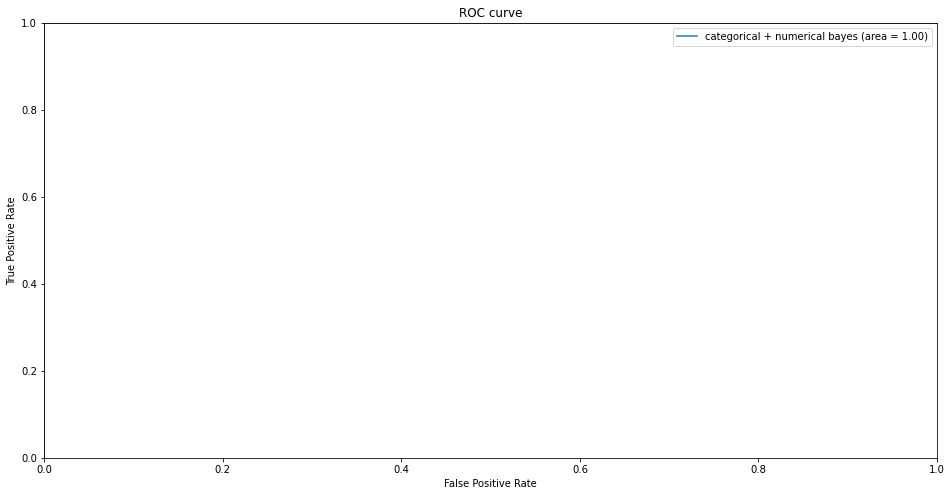

In [10]:
plot_roc(text_clf_nb, x_test, y_test, 'categorical + numerical bayes')

In [11]:
def to_boolean(values: list):
    if values[0] > values[1]:
        return False
    else:
        return True

predicted = text_clf_nb.predict_proba(x_test)

result = []
for x in predicted:
    result.append(to_boolean(x))
    
metrics.accuracy_score(y_test, result)

1.0

In [12]:
df = df.dropna(subset=['name'])
df = df.drop(df[df.name.str.isnumeric()].index)

In [15]:

name_vectorizer = CountVectorizer()
name_vectors = name_vectorizer.fit_transform(df['name'])

blurb_vectorizer = CountVectorizer()
blurb_vectors = blurb_vectorizer.fit_transform(df['blurb'])

# x_features_train is a combined representation containing both the keywords and the text vectors
x_features_train = sp.hstack([name_vectors, blurb_vectors], format='csr')

# y is decided above
x_train_stack, x_test_stack, y_train_stack, y_test_stack = train_test_split(x_features_train, df.funded, test_size=0.2)

text_val_stack, text_val_test_stack, target_val_stack, target_val_test_stack = train_test_split(x_test_stack, y_test_stack, test_size=0.50)

In [16]:
clf_nb_stack = MultinomialNB() 
clf_nb_stack.fit(x_train_stack, y_train_stack)

MultinomialNB()

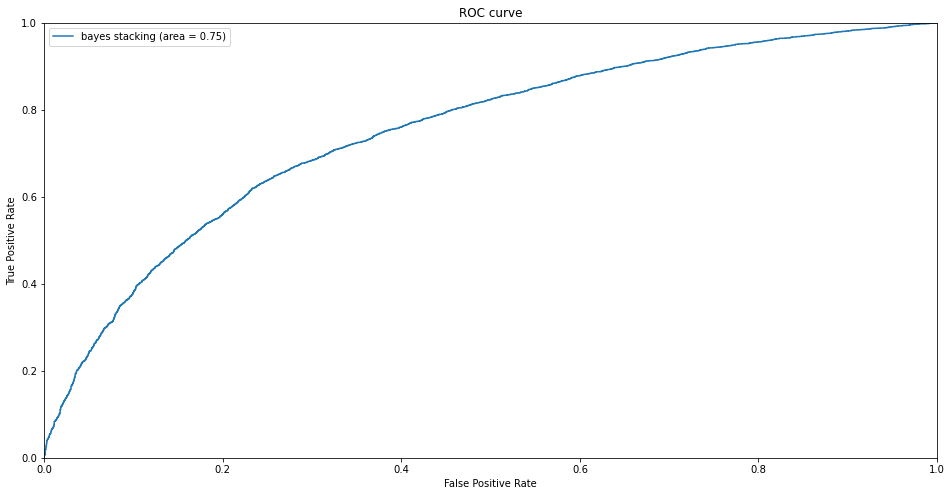

In [17]:
plot_roc(clf_nb_stack, text_val_test_stack, target_val_test_stack, 'bayes stacking')

In [18]:
predicted = clf_nb_stack.predict_proba(x_test_stack)
result = []
for x in predicted:
    result.append(to_boolean(x))
    
metrics.accuracy_score(y_test_stack, result)

0.6943842860740368

In [53]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [('Numerical', text_clf_nb),
              ('textual', clf_nb_stack)]

stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Numerical',
                               Pipeline(steps=[('clf', GaussianNB())])),
                              ('textual', MultinomialNB())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [54]:
predicted = stacking_regressor.predict(x_test_stack)

predicted
result = []
for x in predicted:
    result.append(to_boolean(x))
    
metrics.accuracy_score(y_test_stack, result)

AttributeError: 'StackingRegressor' object has no attribute 'final_estimator_'

# Evaluation: